# Classifying Hotel Reservation Cancelations

1. Initialize & split data
2. EDA
3. Final Model(Random Forest)
4. Run and compare several models

## 1. Initialize & split data
- import libraries
- initialize data
- functions
- split data

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, naive_bayes, ensemble, neighbors, tree
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.metrics import precision_recall_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime as dt
from time import time

import hotels #import hotels.py file with helper functions

In [2]:
# Get pandas and postgres to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql

In [3]:
# There is a bug in matplotlib. You cannot set the rc parameters in the same
# cell that you use the "%matplotlib inline" magic command
plt.style.use('ggplot')
#plt.rc('font', size=10)

Note: postgres database previously created and populated across 3 tables using ```hotel_create_psql_db.ipynb``` notebook

In [4]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',  # We are connecting to our _local_ version of psql
    'dbname': 'hotels',    # DB that we are connecting to
    'port': 5432          
}

connection = pg.connect(**connection_args)
connection.autocommit = False

3 tables can be accessed with these queries:
```
query = "SELECT * FROM booking;"
query = "SELECT * FROM service;"
query = "SELECT * FROM details;"
```

In [5]:
# query = "SELECT * FROM booking;"
query = "SELECT * FROM details;"
# query = "SELECT * FROM details;"

table_df = pd_sql.read_sql(query, connection)
table_df.head()

bookingID      DepositType  DaysInWaitingList CustomerType  \
0          0  No Deposit                       0    Transient   
1          1  No Deposit                       0    Transient   
2          2  No Deposit                       0    Transient   
3          3  No Deposit                       0    Transient   
4          4  No Deposit                       0    Transient   

   IsRepeatedGuest  PreviousCancellations  PreviousBookingsNotCanceled  \
0                0                      0                            0   
1                0                      0                            0   
2                0                      0                            0   
3                0                      0                            0   
4                0                      0                            0   

  MarketSegment DistributionChannel        Agent      Company  
0        Direct              Direct         NULL         NULL  
1        Direct              Direct         NULL         NULL  
2        Direct              Direct         NULL         NULL  
3     Corporate           Corporate          304         NULL  
4     Online TA               TA/TO          240         NULL

Final query for desired features:

In [6]:
query = '''
SELECT 
    booking.*, service."TotalOfSpecialRequests", service."Meal", service."BookingChanges", service."RequiredCarParkingSpaces", details."DepositType", details."CustomerType", details."Agent", details."MarketSegment"
FROM booking, service, details
WHERE booking."bookingID" = service."bookingID"
AND booking."bookingID" = details."bookingID";
        '''
booking_df = pd_sql.read_sql(query, connection)

In [7]:
booking_df.shape

(119390, 25)

In [8]:
#instaed of using each agent as category, turn into binary 0 if didn't use agent and 1 if reservation did use agent
booking_df.loc[(booking_df['Agent'].str.strip() == 'NULL'), 'UsedAgent'] = 0
booking_df.loc[(booking_df['Agent'].str.strip() != 'NULL'), 'UsedAgent'] = 1

#separate country into binary. 0 - not from Portugal. 1 - from Portugal
booking_df.loc[(booking_df.Country != 'PRT'), 'Country'] = 'Other'

#strip out spaces in values in these features
booking_df.DepositType = booking_df.DepositType.str.strip()
booking_df.Meal = booking_df.Meal.str.strip()

#filter out anomoly ADR
booking_df = booking_df[booking_df.ADR < 1000]

In [9]:
#check for NA values
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bookingID                 119389 non-null  int64  
 1   hotel                     119389 non-null  object 
 2   ArrivalDateYear           119389 non-null  int64  
 3   ArrivalDateMonth          119389 non-null  object 
 4   ArrivalDateWeekNumber     119389 non-null  int64  
 5   ArrivalDateDayOfMonth     119389 non-null  int64  
 6   StaysInWeekendNights      119389 non-null  int64  
 7   StaysInWeekNights         119389 non-null  int64  
 8   LeadTime                  119389 non-null  int64  
 9   Adults                    119389 non-null  int64  
 10  Children                  119385 non-null  float64
 11  Babies                    119389 non-null  int64  
 12  Country                   119389 non-null  object 
 13  ADR                       119389 non-null  f

In [21]:
#pull out 20% of data for test
x, y = booking_df.drop('IsCanceled', axis=1), booking_df['IsCanceled']

x_, x_test, y_, y_test = train_test_split(x, y, test_size=.2, random_state=10)

#and another 20% for validate
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=.2, random_state=30)

## 2. Exploratory Data Analysis (EDA)

In [12]:
#put df together to contain target
#not including test set
viz_booking_df = x_.copy()
viz_booking_df['IsCanceled'] = y_

In [13]:
viz_booking_df = hotels.clean_data(viz_booking_df)

In [14]:
viz_booking_df.IsCanceled.value_counts()

0    59530
1    35393
Name: IsCanceled, dtype: int64

In [15]:
#export data to CSV for viz in tableau
viz_booking_df.to_csv("hotel_data2.csv")

View random sampling of data so that plots can generate

In [16]:
import random

rs = np.random.RandomState(40)
    
# Here, we select a sample (`choice`) from all possible unique users
sampling = rs.choice(viz_booking_df['bookingID'], 
                        size=int(viz_booking_df.shape[0] * 0.1), 
                        replace=False)

sampling_df = viz_booking_df[viz_booking_df['bookingID'].isin(sampling)]

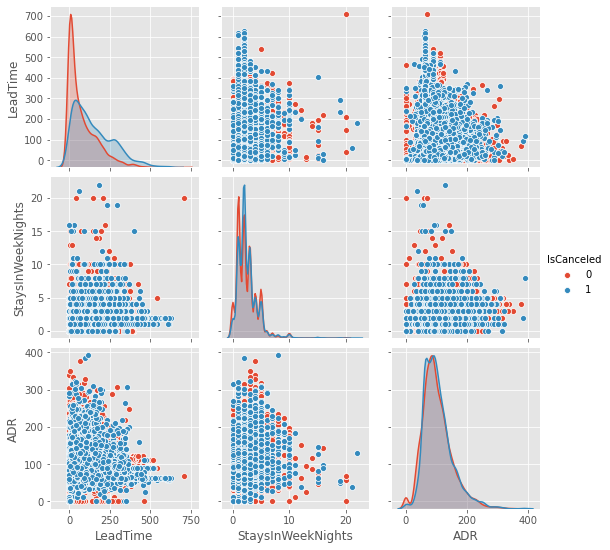

In [17]:
pair_plot = sampling_df[['LeadTime', 'StaysInWeekNights', 'ADR', 'IsCanceled']]
sns.pairplot(pair_plot, hue='IsCanceled')

How many bookings at each hotel per year?

In [33]:
annual_counts = viz_booking_df.groupby(['hotel', 'ArrivalDateYear']).count().reset_index()

sns.set(style="whitegrid")
ax = sns.barplot(x="ArrivalDateYear", y="bookingID", hue="hotel", data=annual_counts)

Per month?

In [34]:
monthly_counts = viz_booking_df.groupby(['hotel', 'ArrivalDateMonth']).count().reset_index()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=[15,3])
ax = sns.barplot(x="ArrivalDateMonth", y="bookingID", hue="hotel", data=monthly_counts, order=months)

Most bookings from Portugal (graphed before making into binary feature)

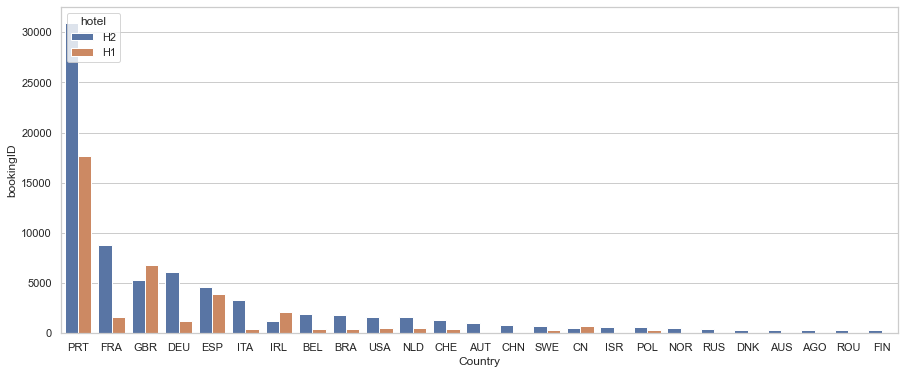

In [28]:
country_counts = booking_df.groupby(['hotel', 'Country']).count().reset_index().sort_values(by='bookingID', ascending=False)
country_counts = country_counts.head(40)

plt.figure(figsize=[15,6])
ax = sns.barplot(x="Country", y="bookingID", hue="hotel", data=country_counts)

How many canceled vs non-canceled reservations per hotel per year?

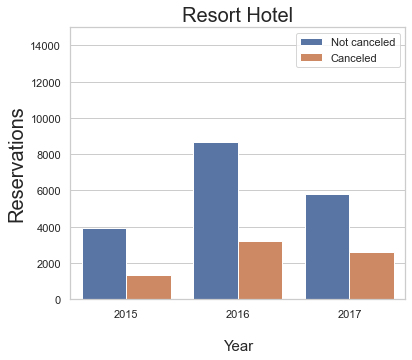

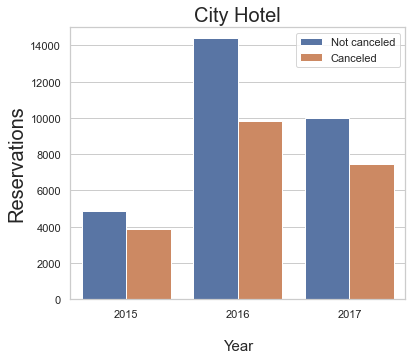

In [463]:
cancel_counts = viz_booking_df.groupby(['hotel','ArrivalDateYear', 'IsCanceled']).count().reset_index()
hotels_ = ['H1', 'H2']

for h in hotels_:
    temp = cancel_counts[(cancel_counts.hotel == h)]

    plt.figure(figsize=[6,5])
    ax = sns.barplot(x="ArrivalDateYear", y="bookingID", hue="IsCanceled", data=temp)
    plt.axis([-0.5, 2.5, 0, 15000])

    if h == 'H1':
        plt.title('Resort Hotel', fontsize=20)
    else:
        plt.title('City Hotel', fontsize=20)

    ax.set_xlabel('\nYear', fontsize=15)
    ax.set_ylabel('Reservations', fontsize=20)

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['Not canceled', 'Canceled'])

Per month in 2016?

In [35]:
cancel_counts = viz_booking_df.groupby(['hotel','ArrivalDateYear', 'ArrivalDateMonth', 'IsCanceled']).count().reset_index()
hotels_ = ['H1', 'H2']

for h in hotels_:
    temp = cancel_counts[(cancel_counts.hotel == h) & (cancel_counts.ArrivalDateYear == 2016)]

    plt.figure(figsize=[14,6])
    ax = sns.barplot(x="ArrivalDateMonth", y="bookingID", hue="IsCanceled", data=temp, order=months)
    plt.axis([-0.5, 11.5, 0, 1600])

    if h == 'H1':
        plt.title('Resort Hotel - Number of reservations per month in 2016\n', fontsize=20)
    else:
        plt.title('City Hotel - Number of reservations per month in 2016\n', fontsize=20)

    ax.set_xlabel('\nArrival Month', fontsize=15)
    ax.set_ylabel('Number of reservations', fontsize=20)

    h, l = ax.get_legend_handles_labels()
    ax.legend(h, ['Not canceled', 'Canceled'], title='Reservations')

Per week?

In [30]:
cancel_counts = viz_booking_df.groupby(['hotel','ArrivalDateYear', 'ArrivalDateWeekNumber', 'IsCanceled']).count().reset_index()
cancel_counts = cancel_counts[(cancel_counts.hotel == 'H2') & (cancel_counts.ArrivalDateYear == 2017)]

plt.figure(figsize=[15,6])
ax = sns.barplot(x="ArrivalDateWeekNumber", y="bookingID", hue="IsCanceled", data=cancel_counts)

## 3. Modeling - Final Model (Random Forest)

- Set initial object/lists

In [11]:
class results:
    def __init__(self, score, auc, cnf_mtrx, report, train_time, test_time):
        self.score = score
        self.auc = auc
        self.cnf_mtrx = cnf_mtrx
        self.report = report
        self.train_time = train_time
        self.test_time = test_time

def run_models(models, X_train, Y_train, X_val, Y_val):
    global cnf_mtrx_dict
    global y_pred
    global model

    for model_tup in models:
        name, model = model_tup
        
        # train
        t0 = time()
        model.fit(X_train, Y_train)
        train_time = time() - t0

        #score validation set
        score = model.score(X_val, Y_val)
        auc = roc_auc_score(Y_val, model.predict_proba(X_val)[:,1])

        #predict on validation set
        t0 = time()
        y_pred = model.predict(X_val)
        test_time = time() - t0

        #pull metrics
        confusion = confusion_matrix(Y_val, y_pred)
        report = classification_report(Y_val, y_pred, target_names=['Not Canceled', 'Is Canceled'])

        #save everything into dictionary/class
        res = results(score, auc, confusion, report, train_time, test_time)
        cnf_mtrx_dict[name] = res
    return

In [12]:
cnf_mtrx_dict = {}

drop_cols = ['ReservationStatus', 'ReservationStatusDate', 'bookingID', 'ArrivalDate', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'ArrivalDateYear', 'ActualLengthOfStay','Babies', 'Agent', 'BookLengthOfStay']
cat_cols = ['hotel','DepositType', 'CustomerType', 'MarketSegment', 'Country', 'ArrivalDateMonth', 'Meal']

- Clean / prep train and validation datasets

In [14]:
x_train_, y_train_ = hotels.transform_set(x_train, y_train, cat_cols, drop_cols)
x_val_, y_val_ = hotels.transform_set(x_val, y_val, cat_cols, drop_cols)

- Make sure columns match on both sets

In [15]:
x_train_, x_val_ = hotels.match_df_cols(x_train_, x_val_)

Removed ['MarketSegment_Undefined'] from df1


- Run random forest

In [16]:
models = [("Random_Forest", ensemble.RandomForestClassifier())]
run_models(models, x_train_, y_train_, x_val_, y_val_)

- Accuracy, timing

In [16]:
for mdl, result in cnf_mtrx_dict.items():
    print(f'{mdl}: {round(result.score,2)}; {round(result.train_time,2)}; {round(result.test_time,2)}')

Random_Forest: 0.87; 8.14; 0.46


- Run 5-fold cross validation to confirm score(accuracy)

In [13]:
x_, y_ = hotels.transform_set(x_, y_, cat_cols, drop_cols)

#this helps with the way kf will generate indices below
x_arr, y_arr = np.array(x_), np.array(y_)

hotels.run_cv(ensemble.RandomForestClassifier(), x_arr, y_arr, 5)

Simple regression scores:  [0.869, 0.866, 0.871, 0.87, 0.866] 

Simple mean cv score: 0.868 +- 0.002


- Random forest additional metrics

In [23]:
#report
for mdl, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.report)

Random_Forest
              precision    recall  f1-score   support

Not Canceled       0.88      0.92      0.90     11825
 Is Canceled       0.86      0.78      0.82      7146

    accuracy                           0.87     18971
   macro avg       0.87      0.85      0.86     18971
weighted avg       0.87      0.87      0.87     18971



In [96]:
#confusion matrix
for mdl, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.cnf_mtrx)

Random_Forest
[[10887   938]
 [ 1555  5591]]


- Shift threshold to 0.6 to tip scales to higher precision

In [17]:
#random forest
y_predict = (model.predict_proba(x_val_)[:,1] > 0.6)
print(classification_report(y_val_, y_predict, target_names=['Not Canceled', 'Is Canceled']))

              precision    recall  f1-score   support

Not Canceled       0.85      0.95      0.90     11825
 Is Canceled       0.90      0.73      0.80      7146

    accuracy                           0.86     18971
   macro avg       0.87      0.84      0.85     18971
weighted avg       0.87      0.86      0.86     18971



- Investigate 14 day cancelations

In [18]:
val_full = x_val.copy()
val_full['IsCanceled'] = y_val

val_full = hotels.clean_data(val_full)
val_full['predicted'] = y_predict

hotels.last_minute_cancel(val_full)

actual_canceled total: 7146
actual_canceled within 14 days: 1652
pred_true_pos total: 5183
pred_true_pos within 14 days: 786


In [19]:
print(f'Recall for 14 day cancelations: {round(768 / 1652, 2)}')

Recall for 14 day cancelations: 0.46


- Run on test set

In [22]:
#clean and transform train/test data
new_x, new_y = hotels.transform_set(x_, y_, cat_cols, drop_cols)
x_test_, y_test_ = hotels.transform_set(x_test, y_test, cat_cols, drop_cols)

#make sure dfs have the same features
new_x, x_test_ = hotels.match_df_cols(new_x, x_test_)

Removed ['MarketSegment_Undefined'] from df1


In [112]:
#run model
models = [("Random_Forest", ensemble.RandomForestClassifier())]
run_models(models, new_x, new_y, x_test_, y_test_)

In [113]:
#print results
for mdl, result in cnf_mtrx_dict.items():
    print(f'{mdl}: {round(result.score,2)}; {round(result.train_time,2)}; {round(result.test_time,2)}')

#report
for mdl, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.report)

#confusion matrix
for mdl, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.cnf_mtrx)

Random_Forest: 0.87; 10.46; 0.6
Random_Forest
              precision    recall  f1-score   support

Not Canceled       0.88      0.92      0.90     14930
 Is Canceled       0.85      0.79      0.82      8821

    accuracy                           0.87     23751
   macro avg       0.87      0.85      0.86     23751
weighted avg       0.87      0.87      0.87     23751

Random_Forest
[[13736  1194]
 [ 1880  6941]]


In [125]:
#adjust threshold
y_predict = (model.predict_proba(x_test_)[:,1] > 0.6)
print(classification_report(y_test_, y_predict, target_names=['Not Canceled', 'Is Canceled']))

              precision    recall  f1-score   support

Not Canceled       0.86      0.95      0.90     14930
 Is Canceled       0.89      0.73      0.80      8821

    accuracy                           0.87     23751
   macro avg       0.87      0.84      0.85     23751
weighted avg       0.87      0.87      0.86     23751



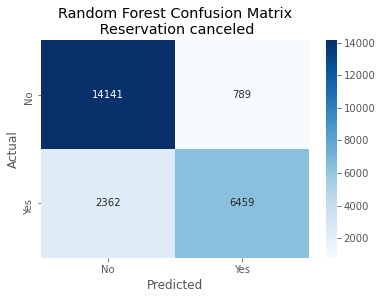

In [121]:
#confusion matrix
rf_confusion = confusion_matrix(y_test_, y_predict)

sns.heatmap(rf_confusion, cmap="Blues", annot=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix\n Reservation canceled');

In [126]:
#recall for 14 day cancels
test_full = x_test.copy()
test_full['IsCanceled'] = y_test

test_full = hotels.clean_data(test_full)
test_full['predicted'] = y_predict

hotels.last_minute_cancel(test_full)

actual_canceled total: 8821
actual_canceled within 14 days: 1972
pred_true_pos total: 6459
pred_true_pos within 14 days: 941


In [127]:
print(f'Recall for 14 day cancelations: {round(941 / 1972, 2)}')

Recall for 14 day cancelations: 0.48


- Random forest feature importance

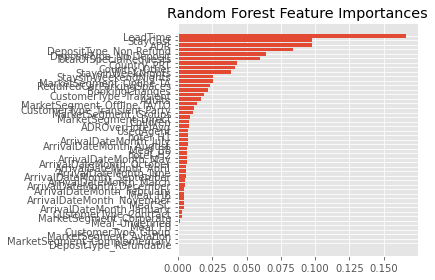

<Figure size 1440x4320 with 0 Axes>

In [129]:
tree_feature_importances = (model.feature_importances_)
sorted_idx = tree_feature_importances.argsort()

feature_names = np.array(new_x.columns)

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.figure(figsize = (20,60))
plt.show()

In [130]:
#top 10 features
feat_imp = pd.DataFrame(list(zip(feature_names[sorted_idx], tree_feature_importances[sorted_idx])))
feat_imp.sort_values(by=1, ascending=False).head(10)

0         1
46                LeadTime  0.166481
45                StayCost  0.097854
44                     ADR  0.097595
43  DepositType_Non Refund  0.083654
42  DepositType_No Deposit  0.063974
41  TotalOfSpecialRequests  0.059987
40             Country_PRT  0.043250
39           Country_Other  0.041652
38       StaysInWeekNights  0.038731
37    StaysInWeekendNights  0.025681

### Run decision tree to get sample tree

View graph tree visualization with [graphviz](www.graphviz.com)

In [131]:
#run model
models = [('Decision_Tree', tree.DecisionTreeClassifier(max_depth=3, random_state=30))] #max depth 3 to limit size of tree
run_models(models, new_x, new_y, x_test_, y_test_)

#save off tree graph info
tree_str = tree.export_graphviz(model, None)

#export to text file
text_file = open("sample.txt", "w")
n = text_file.write(tree_str)
text_file.close()

## 4. Run and compare several models

Executed before choosing random forest

In [135]:
#standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_.values)

#standardize
x_val_scaled = scaler.transform(x_val.values)

In [143]:
#run models
models = [("Logistic_Regression", linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)),
          ("KNN", neighbors.KNeighborsClassifier())]
run_models(models, x_train_scaled, y_train_, x_val_scaled, y_val_)

In [145]:
models = [("Naïve_Bayes", naive_bayes.GaussianNB()),
          ("Random_Forest", ensemble.RandomForestClassifier()),
          ("Gradient_Boosting", ensemble.GradientBoostingClassifier(learning_rate=0.5))]
run_models(models, x_train_, y_train_, x_val_, y_val_)

In [159]:
models = [("XGB_Classifier", xgb.XGBClassifier( 
                       n_estimators=1000, #arbitrary large number
                       max_depth=4,
                       objective='binary:logistic',
                       use_label_encoder=False,
                       learning_rate=0.4, 
                       subsample=0.8,
                       min_child_weight=3,
                       colsample_bytree=.8))]
run_models(models, x_train_, y_train_, x_val_, y_val_)

[20:32:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [150]:
#print results
for mdl, result in cnf_mtrx_dict.items():
    print(f'{mdl}: {round(result.score,2)}; {round(result.train_time,2)}; {round(result.test_time,2)}')

Random_Forest: 0.87; 8.23; 0.46
Decision_Tree: 0.76; 0.18; 0.0
Logistic_Regression: 0.8; 0.68; 0.0
KNN: 0.83; 7.34; 95.17
Naïve_Bayes: 0.72; 0.09; 0.02
Gradient_Boosting: 0.84; 10.81; 0.03
XGB_Classifier: 0.86; 19.31; 0.04


In [151]:
#print report
for mdl, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.report)

Random_Forest
              precision    recall  f1-score   support

Not Canceled       0.87      0.92      0.90     11825
 Is Canceled       0.86      0.78      0.82      7146

    accuracy                           0.87     18971
   macro avg       0.87      0.85      0.86     18971
weighted avg       0.87      0.87      0.87     18971

Decision_Tree
              precision    recall  f1-score   support

Not Canceled       0.78      0.86      0.82     14930
 Is Canceled       0.71      0.60      0.65      8821

    accuracy                           0.76     23751
   macro avg       0.75      0.73      0.73     23751
weighted avg       0.76      0.76      0.76     23751

Logistic_Regression
              precision    recall  f1-score   support

Not Canceled       0.79      0.91      0.85     11825
 Is Canceled       0.80      0.61      0.69      7146

    accuracy                           0.80     18971
   macro avg       0.80      0.76      0.77     18971
weighted avg       0.80   

In [153]:
#AUC
for mdl, result in cnf_mtrx_dict.items():
    print(mdl, 'auc', round(result.auc,2))

Random_Forest auc 0.94
Decision_Tree auc 0.78
Logistic_Regression auc 0.87
KNN auc 0.9
Naïve_Bayes auc 0.81
Gradient_Boosting auc 0.92
XGB_Classifier auc 0.93


In [160]:
#confusion matrix
for mdll, result in cnf_mtrx_dict.items():
    print(mdl)
    print(result.cnf_mtrx)

XGB_Classifier
[[10890   935]
 [ 1556  5590]]
XGB_Classifier
[[12816  2114]
 [ 3566  5255]]
XGB_Classifier
[[10728  1097]
 [ 2787  4359]]
XGB_Classifier
[[10463  1362]
 [ 1862  5284]]
XGB_Classifier
[[8280 3545]
 [1846 5300]]
XGB_Classifier
[[10690  1135]
 [ 1851  5295]]
XGB_Classifier
[[10697  1128]
 [ 1591  5555]]


### Comparing XGBoost and Random Forest

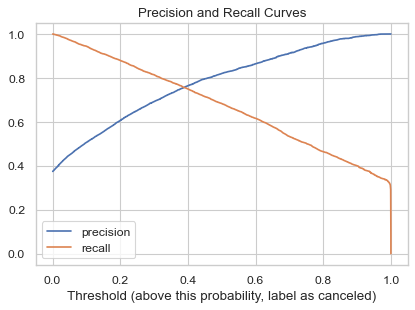

In [721]:
#XB Boost
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_, model.predict_proba(x_val_)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as canceled)');
plt.title('Precision and Recall Curves');

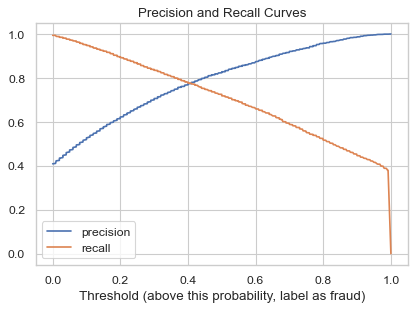

In [706]:
#Random forest
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val_, model.predict_proba(x_val_)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as canceled)');
plt.title('Precision and Recall Curves');

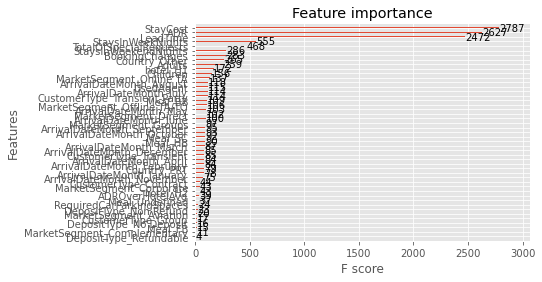

In [161]:
#XGBoost feature importance
xgb.plot_importance(model)